ott-jax commit hash: 72885ac75491d98e55b4f039c583134d3c2ba7b7

In [1]:
from typing import Iterator, Literal, Optional, Union
import functools
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import optax
import jax
import ott
from genot.nets.nets import MLP_vector_field, MLP_marginal
from ott.solvers.linear import sinkhorn, acceleration
from ott.geometry import costs

from ott.solvers.utils import uniform_sampler
from genot.data.data import MixtureNormalSampler
from genot.models.model import GENOT

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-05 14:52:57.675623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733406778.564265  940328 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733406778.869933  940328 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
@jax.tree_util.register_pytree_node_class
class CoulombCost(costs.CostFn):
    def pairwise(self, x: jnp.ndarray, y: jnp.ndarray) -> float:
        return 1.0/(jnp.linalg.norm((x-y), ord=2, axis=-1))**2

In [3]:
source_1 = jax.random.multivariate_normal(jax.random.PRNGKey(1), np.array([-2, -2]), 0.05*np.eye(2), (5000,))
source_2 = jax.random.multivariate_normal(jax.random.PRNGKey(1), np.array([-2, 2]), 0.05*np.eye(2), (5000,))

target_1 = jax.random.multivariate_normal(jax.random.PRNGKey(1), np.array([2, -2]), 0.05*np.eye(2), (5000,))
target_2 = jax.random.multivariate_normal(jax.random.PRNGKey(1), np.array([2, 2]), 0.05*np.eye(2), (5000,))

In [4]:
source = jax.random.permutation(jax.random.PRNGKey(0), jnp.concatenate((source_1, source_2), axis=0))
target = jax.random.permutation(jax.random.PRNGKey(0), jnp.concatenate((target_1, target_2), axis=0))

In [5]:
#dl = OTDataLoader(1024, source_lin=source, target_lin=target)

In [6]:
source_test = source[:50] #50

In [7]:
epsilon=1e-3
iterations=3_000
source_dim = 2
target_dim = 2
condition_dim = 0
latent_embed_dim = 256
n_frequencies = 1024

# GENOT

In [8]:
neural_vf = MLP_vector_field(output_dim=target_dim,
                             condition_embed_dim = source_dim + condition_dim,
                             latent_embed_dim=latent_embed_dim,
                             n_frequencies=n_frequencies)

ot_solver = sinkhorn.Sinkhorn()
cost_fn = CoulombCost()
time_sampler = uniform_sampler
optimizer = optax.adam(learning_rate=1e-4)
genot = GENOT(
    neural_vf,
    input_dim=source_dim,
    output_dim=target_dim,
    iterations=iterations,
    ot_solver=ot_solver,
    epsilon=epsilon,
    cost_fn=cost_fn,
    scale_cost=1.0,
    optimizer=optimizer,
    solver_latent_to_data=None,
)
genot(source, target, 1024, 1024)

I0000 00:00:1733406884.522231  940328 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6706 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:9b:00.0, compute capability: 7.0
100%|██████████| 3000/3000 [02:17<00:00, 21.75it/s]


In [9]:
result_genot = genot.transport(
    source_test
)

(-3.0, 3.0)

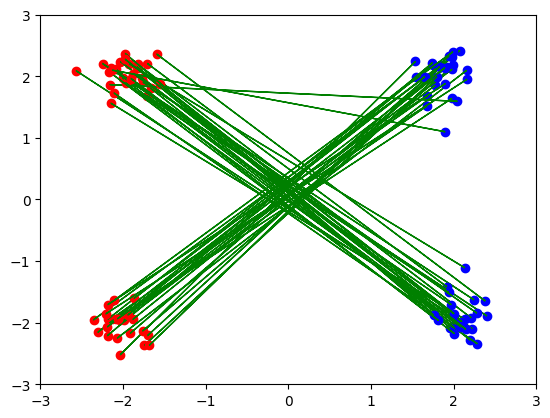

In [10]:
for source_point, target_point in zip(source_test, result_genot[0][0]):
    plt.scatter(*source_point, color='red')  # Plot source point
    plt.scatter(*target_point, color='blue')   # Plot target point
    plt.arrow(source_point[0], source_point[1],  # Draw arrow
              target_point[0] - source_point[0], target_point[1] - source_point[1],
              color='green', width=0.001, head_width=0.01, length_includes_head=True)

plt.xlim((-3, 3))
plt.ylim((-3, 3))